In [1]:
import torch 
import random
import numpy as np
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import cv2


In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

# DataSet

## 데이터 불러오기

In [109]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')
from sklearn.model_selection import train_test_split

# train : valid =  0.9 : 0.1
train, valid = train_test_split(train, 
                                test_size=0.1,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                                random_state=42)

# EDA

## 데이터 훑어보기

In [110]:
train.shape, test.shape

((1638, 5), (1821, 1))

In [111]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
379,Train_379,0,0,0,1
1556,Train_1556,1,0,0,0
448,Train_448,1,0,0,0
1202,Train_1202,0,0,0,1
1541,Train_1541,1,0,0,0


In [112]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [113]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


- healthy : 건강함
- multiple_diseases : 여러 질병
- rust : 녹병균
- scab : 붉은 곰팡이병

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 379 to 1746
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1638 non-null   object
 1   healthy            1638 non-null   int64 
 2   multiple_diseases  1638 non-null   int64 
 3   rust               1638 non-null   int64 
 4   scab               1638 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 76.8+ KB


## 데이터 시각화

In [115]:
# Extract data for each target value
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

In [137]:
healthy.shape, multiple_diseases.shape, rust.shape, scab.shape

((464, 5), (82, 5), (559, 5), (533, 5))

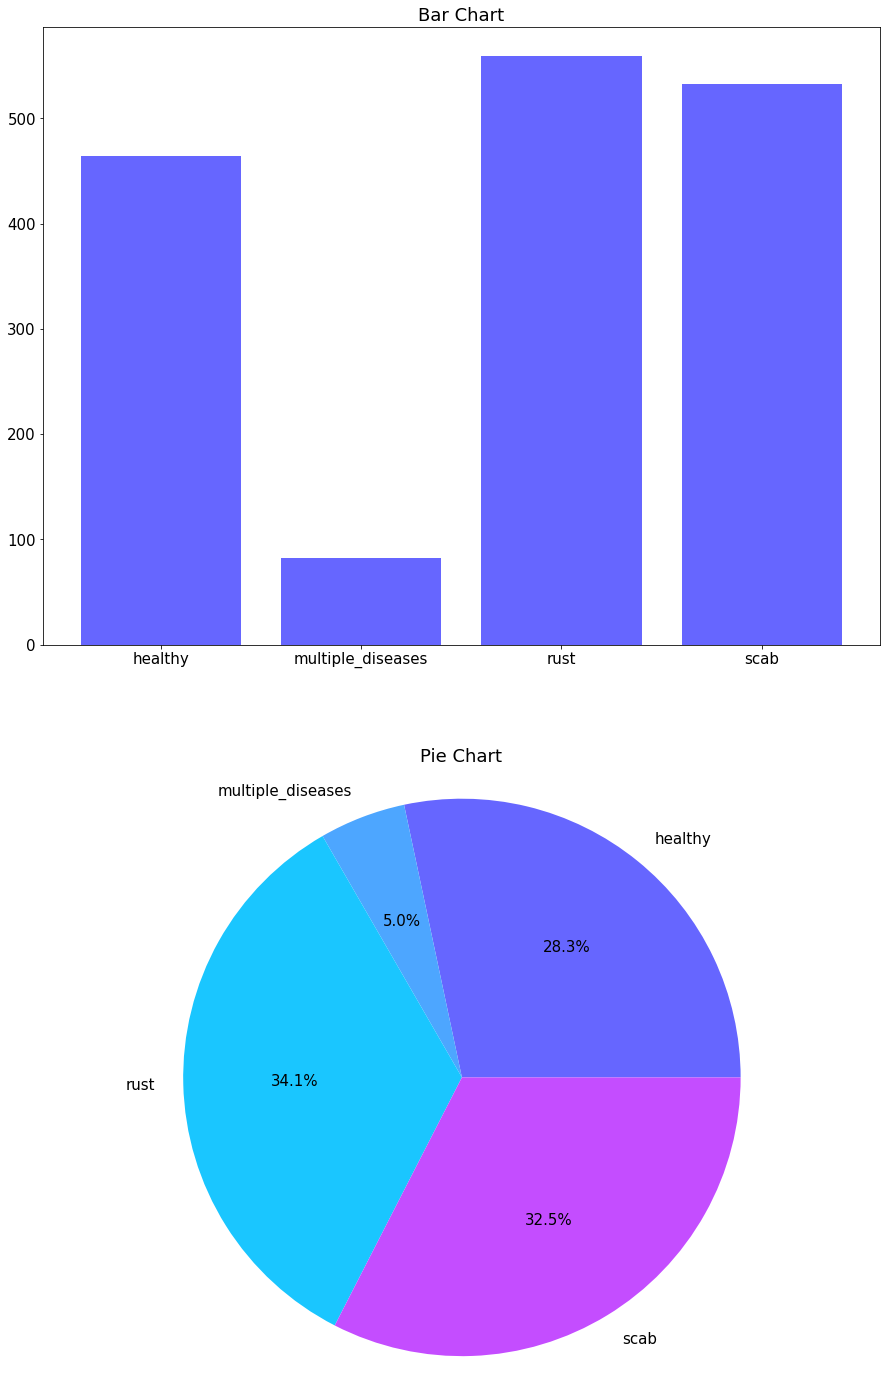

In [138]:
diseases = dict()

for column in ["healthy","multiple_diseases","rust","scab"]:
    counts = pd.DataFrame(train[column].value_counts())
    diseases[column] = counts.iloc[1,0]
    
#bar chart to show different diseases    
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,25))
ax1.bar(diseases.keys(),diseases.values(), color=["#6666ff"])
ax1.set_title('Bar Chart', fontsize=18)

ax2.pie(diseases.values(),labels = diseases.keys(), colors=["#6666ff","#4da6ff","#1ac6ff","#c44dff"], autopct='%1.1f%%')
ax2.set_title('Pie Chart', fontsize=18)
ax2.axis('equal') 

plt.show()

In [140]:

def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows * cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    plt.figure(figsize=(15,8))
    grid = gridspec.GridSpec(rows, cols)
    
    for idx, img_id in enumerate(img_ids):
        img_path = f'{data_path}/images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

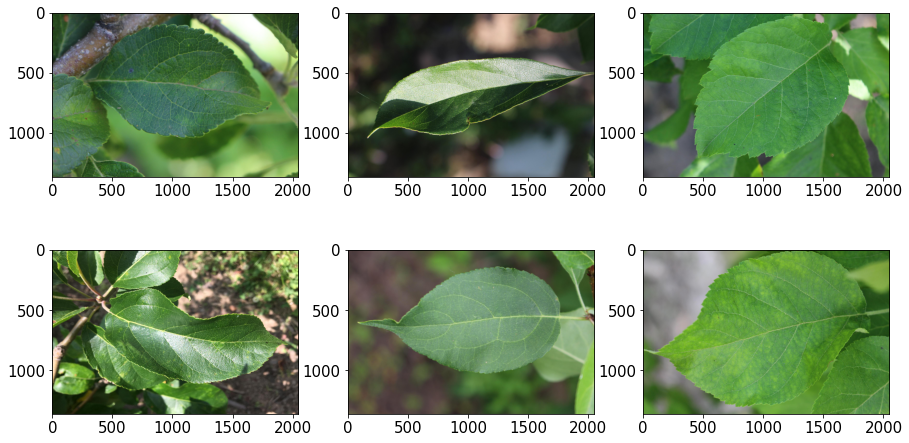

In [142]:
num_of_imgs=6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]
show_image(last_healthy_img_ids)

Text(0.5, 1.0, '3')

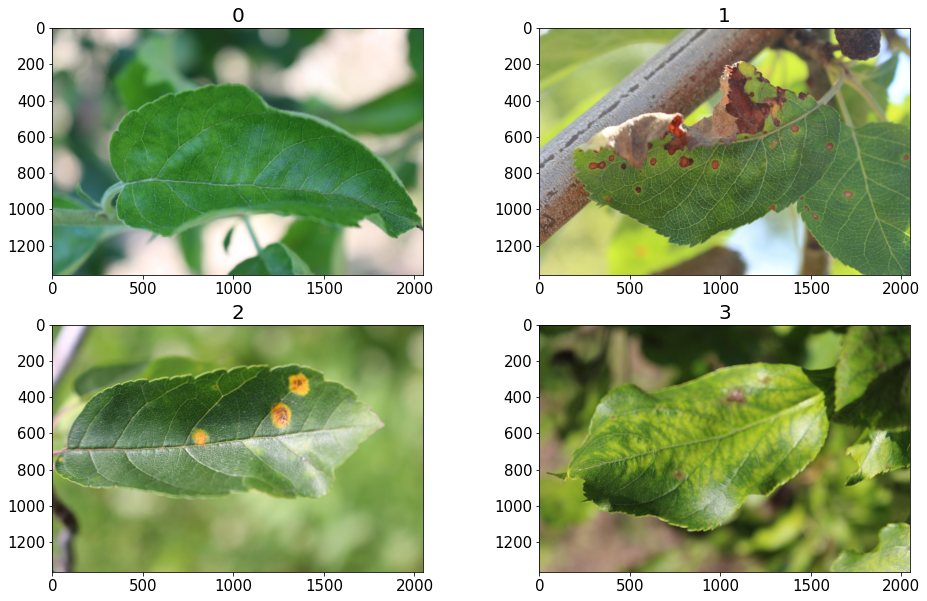

In [118]:
im_healthy = plt.imread(data_path+'/images/Train_2.jpg', format = 'jpg')
im_multi = plt.imread(data_path+'/images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread(data_path+'/images/Train_3.jpg', format = 'jpg')
im_scab = plt.imread(data_path+'/images/Train_0.jpg', format = 'jpg')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_healthy)
ax.set_title(0, fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(im_multi)
ax.set_title(1, fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_rust)
ax.set_title(2, fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(im_scab)
ax.set_title(3, fontsize = 20)

# 데이터 전처리

In [119]:
import cv2
from torch.utils.data import Dataset 
import numpy as np

class ImageDataset(Dataset):
    # 생성자
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    # 데이터셋 반환
    def __len__(self):
        return len(self.df)

    # index해당 반환
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # ID
        img_path = self.img_dir + img_id + '.jpg' # 경로
        image = cv2.imread(img_path)              # 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 색상 보정
        # 이미지 변환 
        if self.transform is not None:
            image = self.transform(image=image)['image']
        if self.is_test:
            return image 
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스 
            label = np.argmax(self.df.iloc[idx, 1:5]) 
            return image, label # 훈련/검증용일 때

In [6]:
# 이미지 변환(albumentations)
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [133]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    
    A.HorizontalFlip(p=0.5),   
    A.ShiftScaleRotate(       
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), 
    A.Normalize(),            
    ToTensorV2()             
])

In [134]:
transform_test = A.Compose([
    A.Resize(450, 650),
    A.Normalize(),      
    ToTensorV2()       
])

In [9]:
img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [10]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

작업속도를 위한 멀티프로세싱

In [11]:
from torch.utils.data import DataLoader

batch_size = 4

trainloader = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
validloader = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
testloader = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [33]:
testloader = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

# Create Model

> EfficientNet-B07

In [12]:
!pip install efficientnet-pytorch==0.7.1
from efficientnet_pytorch import EfficientNet # EfficientNet 모델
# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) 
model = model.to(device)

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4ad2699be0275e07618b737be6d3a17ad967edc977cfc9a76e14bb3843a9ec32
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


> ResNet50

In [29]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# from torchvision import models

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = models.resnet50(pretrained=True).to(device) 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Model Compile

In [30]:
import torch.nn as nn # 신경망 모듈
from tqdm import tqdm
# 크로스엔트로피 손실함수 설정(다중분류)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001) # 모델파라미터,러닝레이트, 가중치감쇠
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1, verbose=True)

# Training Model

In [14]:
def validation(model, validloader, criterion):
  valid_accuracy = 0
  valid_loss = 0

  with torch.no_grad():
    for images, labels in validloader: 
      
      images, labels = images.to(device), labels.to(device)

      # Predict forward
      logits = model.forward(images) 
      _, preds = torch.max(logits, 1)
      # preds= probs.max(dim=1)[1] 
      correct = (preds == labels).sum()

      accuracy = correct / images.shape[0]
      loss = criterion(logits, labels) 
      
      valid_accuracy += accuracy
      valid_loss += loss.item() 
    

  return valid_loss, valid_accuracy


In [15]:
from torch.utils.tensorboard import SummaryWriter

writer  = SummaryWriter()

In [16]:
def train(model, epochs, criterion, optimizer):
  train_loss = []
  valid_loss = []
  train_acc = []
  val_acc = []
  steps = 0
  min_loss = 10000
  max_accuracy = 0

  trigger = 0
  patience = 5 # for Early stopping

  # 1 에폭(epoch)당 반복수
  steps_per_epoch = len(trainloader) # 2500 iterations

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in tqdm(trainloader): # 미니배치 16개씩을 가져와 images, labels에 준비
      steps += 1
      # Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 입력 데이터 준비
      # not Flatten!!
      # images.resize_(images.size()[0], 784) # 16, 1, 28, 28

      # Forward 예측
      outputs = model.forward(images) 
      loss = criterion(outputs, labels) 

      # Backward Gradient 전파
      optimizer.zero_grad() #  gradient가 누적되지 않게 하기 위해
      loss.backward()

      # 경사하강법
      optimizer.step()

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0:
        model.eval() 
        valid_loss, valid_accuracy = validation(model, validloader, criterion)

        # tensorboad 시각화
        writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
        writer.add_scalar("Loss/valid", valid_loss/len(validloader), epoch)
        writer.add_scalars("Loss/train and valid",
                          {'train' : train_loss/len(trainloader),
                          'valid' : valid_loss/len(validloader)}, epoch)
        
        writer.add_scalar("Valid Accuracy", valid_accuracy/len(validloader), epoch)


        print('Epoch : {}/{}.....'.format(epoch+1, epochs),
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
              'Valid Accuracy : {:.3f}'.format(valid_accuracy/len(validloader)))
      

        if valid_accuracy > max_accuracy: 
          max_accuracy = valid_accuracy
          torch.save(model.state_dict(), 'best_checkpoint.pth')

        # Early Stopping
        if valid_loss > min_loss:
          trigger += 1 # valid loss가 min_loss 를 갱신하지 못할때마다 증가
          print('trigger : ', trigger )
          if trigger > patience:
            print('Early Stopping!!!')
            print('Traning step is finished!!')
            writer.flush()  
            return   
        else:
          trigger = 0
          min_loss = valid_loss


        train_loss = 0
        model.train()

        # Learning Rate Scheduler
        scheduler.step(valid_loss)
  plt.figure()
  plt.ylim(0,1.5)
  sns.lineplot(list(range(len(train_loss))), train_loss)
  sns.lineplot(list(range(len(valid_loss))), valid_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Val'])
  writer.flush()      

In [31]:
epochs=20
train(model, epochs, criterion, optimizer)

100%|█████████▉| 409/410 [04:02<00:00,  1.15it/s]

Epoch : 1/20..... Train Loss : 1.125 Valid Loss : 0.272 Valid Accuracy : 0.908


100%|█████████▉| 409/410 [03:56<00:00,  2.39it/s]

Epoch : 2/20..... Train Loss : 0.458 Valid Loss : 0.224 Valid Accuracy : 0.940


100%|██████████| 410/410 [04:13<00:00,  1.62it/s]


Epoch : 3/20..... Train Loss : 0.342 Valid Loss : 0.200 Valid Accuracy : 0.924


100%|██████████| 410/410 [04:05<00:00,  1.67it/s]


Epoch : 4/20..... Train Loss : 0.283 Valid Loss : 0.229 Valid Accuracy : 0.940
trigger :  1


100%|█████████▉| 409/410 [04:06<00:00,  1.74it/s]

Epoch : 5/20..... Train Loss : 0.232 Valid Loss : 0.182 Valid Accuracy : 0.946


100%|██████████| 410/410 [04:04<00:00,  1.68it/s]


Epoch : 6/20..... Train Loss : 0.252 Valid Loss : 0.169 Valid Accuracy : 0.929


100%|██████████| 410/410 [04:14<00:00,  1.61it/s]


Epoch : 7/20..... Train Loss : 0.197 Valid Loss : 0.241 Valid Accuracy : 0.924
trigger :  1


100%|██████████| 410/410 [04:14<00:00,  1.61it/s]


Epoch : 8/20..... Train Loss : 0.174 Valid Loss : 0.181 Valid Accuracy : 0.946
trigger :  2


100%|█████████▉| 409/410 [04:04<00:00,  1.89it/s]

Epoch : 9/20..... Train Loss : 0.140 Valid Loss : 0.198 Valid Accuracy : 0.951


100%|██████████| 410/410 [04:13<00:00,  1.62it/s]


trigger :  3


100%|██████████| 410/410 [04:07<00:00,  1.66it/s]


Epoch : 10/20..... Train Loss : 0.147 Valid Loss : 0.181 Valid Accuracy : 0.946
trigger :  4


100%|█████████▉| 409/410 [04:15<00:00,  1.88it/s]

Epoch : 11/20..... Train Loss : 0.134 Valid Loss : 0.122 Valid Accuracy : 0.962


100%|██████████| 410/410 [04:03<00:00,  1.68it/s]


Epoch : 12/20..... Train Loss : 0.153 Valid Loss : 0.163 Valid Accuracy : 0.951
trigger :  1


100%|██████████| 410/410 [04:15<00:00,  1.60it/s]


Epoch : 13/20..... Train Loss : 0.132 Valid Loss : 0.193 Valid Accuracy : 0.951
trigger :  2


100%|██████████| 410/410 [04:17<00:00,  1.59it/s]


Epoch : 14/20..... Train Loss : 0.124 Valid Loss : 0.163 Valid Accuracy : 0.962
trigger :  3


100%|██████████| 410/410 [04:15<00:00,  1.60it/s]


Epoch : 15/20..... Train Loss : 0.120 Valid Loss : 0.148 Valid Accuracy : 0.957
trigger :  4


100%|█████████▉| 409/410 [04:05<00:00,  2.06it/s]

Epoch : 16/20..... Train Loss : 0.080 Valid Loss : 0.187 Valid Accuracy : 0.973


100%|██████████| 410/410 [04:14<00:00,  1.61it/s]


trigger :  5


100%|█████████▉| 409/410 [04:21<00:00,  1.57it/s]

Epoch : 17/20..... Train Loss : 0.108 Valid Loss : 0.241 Valid Accuracy : 0.946
trigger :  6
Early Stopping!!!
Traning step is finished!!


# Save Model

In [37]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [50]:
torch.save(model, f'./model.pt')

# Test Submission

In [56]:
dataset_test = ImageDataset(test, img_dir=img_dir, 
                            transform=transform_test, is_test=True)


# TTA용 데이터셋 및 데이터 로더
dataset_TTA = ImageDataset(test, img_dir=img_dir, 
                           transform=transform_train, is_test=True)
loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, 
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=2)

In [ ]:
model.eval() # 모델을 평가 상태로 설정 

preds_test = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(testloader):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part
submission_test = submission.copy() # 제출 샘플 파일 복사

submission_test[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_test

In [28]:
submission_test.to_csv('submission_test.csv', index=False)
# submission_tta.to_csv('submission_tta.csv', index=False)

In [131]:
# predict = []
# for batch_idx in tqdm(enumerate(testloader)):
#     data = d['image'].cuda()
    
#     output = model(data)
#     output = output.cpu().detach().numpy()
    #output = np.argmax(output)
#     predict.append(output)
    #print(output)

0it [00:00, ?it/s]


IndexError: too many indices for tensor of dimension 4